In [1]:
import pandas as pd
import datetime as dt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings

# Define the start and end dates
start = dt.datetime(2021, 6, 1)
end = dt.datetime(2022, 1, 5)
symbol = 'AXISBANK.NS'

# Fetch stock data
stk_data = yf.download(symbol, start=start, end=end)
stk_data = stk_data[['Open', 'High', 'Low', 'Close']]


[*********************100%%**********************]  1 of 1 completed


In [3]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(stk_data)
data_normalized = pd.DataFrame(data_normalized, columns=["Open", "High", "Low", "Close"])

In [6]:
training_size = round(len(data_normalized) * 0.80)
X_train = data_normalized[:training_size]
X_test = data_normalized[training_size:]
y_train = data_normalized[:training_size]
y_test = data_normalized[training_size:]
print("Training Size:",training_size)
print("*******************")
print("X_train:",X_train)
print("*******************")
print("X_test:",X_test)
print("*******************")
print("y_train:",y_train)
print("*******************")
print("y_test:",y_test)
print("*******************")
y_test["Close"]

Training Size: 120
*******************
X_train:          Open      High       Low     Close
0    0.526696  0.439563  0.524937  0.484794
1    0.483034  0.396376  0.485771  0.442784
2    0.474052  0.430876  0.512820  0.513145
3    0.513972  0.468851  0.519019  0.468814
4    0.474551  0.439315  0.526909  0.515464
..        ...       ...       ...       ...
115  0.425399  0.336808  0.413074  0.386856
116  0.364271  0.295110  0.331079  0.315722
117  0.334331  0.250931  0.303748  0.284794
118  0.324351  0.236039  0.165681  0.181959
119  0.164671  0.135021  0.165399  0.178093

[120 rows x 4 columns]
*******************
X_test:          Open      High       Low     Close
120  0.209581  0.147183  0.191885  0.175516
121  0.189621  0.106974  0.160890  0.148454
122  0.104790  0.046910  0.070161  0.054897
123  0.085080  0.000000  0.007608  0.000000
124  0.000000  0.059568  0.000000  0.023454
125  0.084331  0.079176  0.067625  0.146907
126  0.134731  0.066269  0.112989  0.128866
127  0.155189  0.108

120    0.175516
121    0.148454
122    0.054897
123    0.000000
124    0.023454
125    0.146907
126    0.128866
127    0.112887
128    0.061856
129    0.185052
130    0.237113
131    0.220876
132    0.190464
133    0.272681
134    0.308248
135    0.316495
136    0.301804
137    0.194846
138    0.119845
139    0.076031
140    0.094072
141    0.142784
142    0.084536
143    0.108505
144    0.125516
145    0.100000
146    0.091495
147    0.141495
148    0.233247
149    0.299227
Name: Close, dtype: float64

In [9]:
test_obs = 28
train = data_normalized[:-test_obs]
test = data_normalized[-test_obs:]

In [11]:
warnings.filterwarnings("ignore")

In [12]:
best_aic = float("inf")
best_order = None
best_model = None

for p in range(1, 6):
    for q in range(1, 6):
        try:
            model = VARMAX(endog=train, exog=None, order=(p, q), trend='c', error_cov_type='unstructured', enforce_stationarity=True)
            results = model.fit(disp=False)
            print(f'Order (p, q) = ({p}, {q})')
            print('AIC: ', results.aic)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_model = results
        except Exception as e:
            continue

print(f'Best order: {best_order}, AIC: {best_aic}')

Order (p, q) = (1, 1)
AIC:  -2015.4172378872727
Order (p, q) = (1, 2)
AIC:  -2018.2328096723904
Order (p, q) = (1, 3)
AIC:  -1994.8463104159628
Order (p, q) = (1, 4)
AIC:  -1966.2505974301262
Order (p, q) = (1, 5)
AIC:  4668996.742866891
Order (p, q) = (2, 1)
AIC:  -2031.8592772456295
Order (p, q) = (2, 2)
AIC:  -2002.1650003362033
Order (p, q) = (2, 3)
AIC:  -1976.8158016665734
Order (p, q) = (2, 4)
AIC:  -1955.6363507263732
Order (p, q) = (2, 5)
AIC:  -1923.572919749417
Order (p, q) = (3, 1)
AIC:  2766.9476596819804
Order (p, q) = (3, 2)
AIC:  -1977.6540834503398
Order (p, q) = (3, 3)
AIC:  4498.967871071055
Order (p, q) = (3, 4)
AIC:  4307.949130759762
Order (p, q) = (3, 5)
AIC:  -1901.8123285092702
Order (p, q) = (4, 1)
AIC:  -1987.8746385162804
Order (p, q) = (4, 2)
AIC:  -1956.9674640397411
Order (p, q) = (4, 3)
AIC:  -1927.0359737167778
Order (p, q) = (4, 4)
AIC:  -1899.3462970665723
Order (p, q) = (4, 5)
AIC:  -1880.5381484915115
Best order: (2, 1), AIC: -2031.8592772456295


In [13]:
forecast = best_model.get_forecast(steps=test_obs).predicted_mean
forecast_df = pd.DataFrame(forecast, columns=["Open", "High", "Low", "Close"])

# Calculate performance metrics
rmse = mean_squared_error(test, forecast_df, squared=False)
mape = mean_absolute_percentage_error(test, forecast_df)

# Display performance metrics
performance = {
    "Model": ["VARMA"],
    "RMSE": [rmse],
    "MAPE": [mape],
    "Lag": [best_order],
    "Test": [test_obs]
}
perf = pd.DataFrame(performance)
print(perf)

   Model      RMSE          MAPE     Lag  Test
0  VARMA  0.288736  2.987686e+13  (2, 1)    28


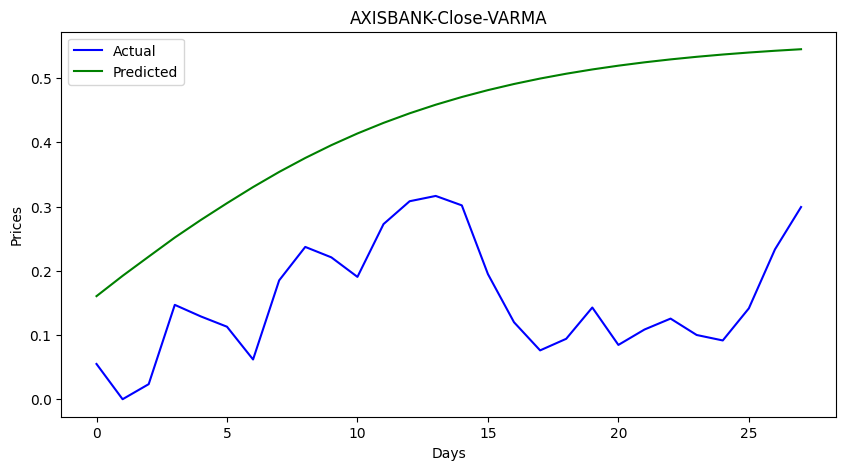

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(test["Close"].values, color='blue', label="Actual")
plt.plot(forecast_df["Close"].values, color='green', label="Predicted")
plt.title("AXISBANK-Close-VARMA")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()

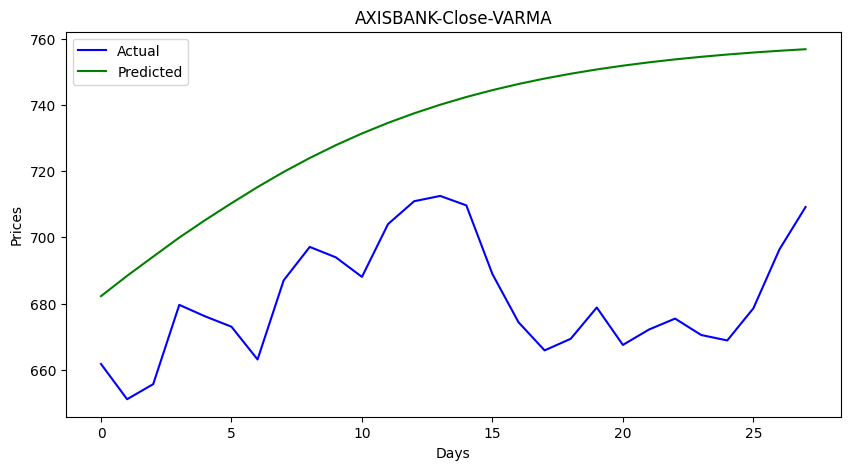

In [15]:
actual_stock_price_test_ori = scaler.inverse_transform(test)
actual_stock_price_test_ori_df = pd.DataFrame(actual_stock_price_test_ori, columns=["Open", "High", "Low", "Close"])

predicted_stock_price_test_ori = scaler.inverse_transform(forecast_df)
predicted_stock_price_test_ori_df = pd.DataFrame(predicted_stock_price_test_ori, columns=["Open", "High", "Low", "Close"])

# Plotting actual vs. predicted values on original scale
plt.figure(figsize=(10, 5))
plt.plot(actual_stock_price_test_ori_df["Close"], color='blue', label="Actual")
plt.plot(predicted_stock_price_test_ori_df["Close"], color='green', label="Predicted")
plt.title("AXISBANK-Close-VARMA")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [16]:
predicted_stock_price_test_ori_df

,Open,High,Low,Close
0,680.596131,686.278314,675.371355,682.231690
1,682.801869,689.851221,681.441225,688.364105
2,688.686090,696.255612,688.240711,694.170914
3,694.218306,701.728150,694.163268,699.930693
4,700.033050,707.268178,699.343646,705.249337
5,705.332761,712.583143,704.418691,710.306998
6,710.458602,717.756060,709.138036,715.182080
7,715.384595,722.673124,713.577430,719.748348
8,720.011888,727.302265,717.676294,723.962713
9,724.291463,731.575473,721.414435,727.838075


RMSE-Testset (Original): 56.584700702240475
MAPE-Testset (Original): 0.07634736063997072


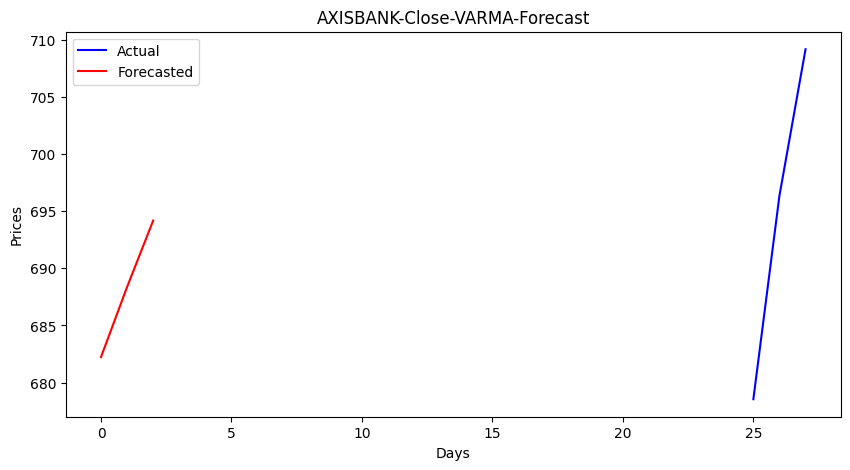

In [17]:
rmse_ori = mean_squared_error(actual_stock_price_test_ori_df["Close"], predicted_stock_price_test_ori_df["Close"], squared=False)
mape_ori = mean_absolute_percentage_error(actual_stock_price_test_ori_df["Close"], predicted_stock_price_test_ori_df["Close"])
print("RMSE-Testset (Original):", rmse_ori)
print("MAPE-Testset (Original):", mape_ori)

# Forecast future prices
forecast_steps = 3  # Adjust as needed
forecast_future = best_model.get_forecast(steps=forecast_steps).predicted_mean
forecast_future_df = pd.DataFrame(forecast_future, columns=["Open", "High", "Low", "Close"])

# Inverse transform future forecast to original scale
forecast_future_prices = scaler.inverse_transform(forecast_future_df)
forecast_future_prices_df = pd.DataFrame(forecast_future_prices, columns=["Open", "High", "Low", "Close"])

# Save forecasted prices
forecast_future_prices_df.to_csv("CloseVARMAForecast.csv", index=False)

# Plotting actual vs. forecasted future prices
plt.figure(figsize=(10, 5))
plt.plot(actual_stock_price_test_ori_df["Close"].iloc[-forecast_steps:], color='blue', label="Actual")
plt.plot(forecast_future_prices_df["Close"], color='red', label="Forecasted")
plt.title("AXISBANK-Close-VARMA-Forecast")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()